<a href="https://colab.research.google.com/github/abdulwasaeee/NUS-assignments/blob/main/HR_data_workshop_AHMEDABDULWASAEANNAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PSUPR Clustering Submission Workshop

 - Objective: Understanding and Profiling Staff Attrition using cluster techniques
 - July 2025

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")

# 1. Import Data

In [2]:
# For this workshop ... download the data from
# https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset

In [4]:
df = pd.read_csv('datad5.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# 2. Variance Threshold

 - There are a few columns with low or zero variance.
 - You should remove them.
 - Note: You need to identify categorcial and numerical features to check for variance

In [5]:
from sklearn.feature_selection import VarianceThreshold

# Separate numerical and categorical features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

print("Numeric features:", list(numeric_features))
print("Categorical features:", list(categorical_features))

# Apply VarianceThreshold only on numeric features
selector = VarianceThreshold(threshold=0.0)  # remove features with 0 variance
selector.fit(df[numeric_features])

# Get kept features
kept_numeric = numeric_features[selector.get_support(indices=True)]
removed_numeric = numeric_features[~selector.get_support(indices=True)]

print("\nKept numeric features:", list(kept_numeric))
print("Removed numeric features (zero variance):", list(removed_numeric))


Numeric features: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categorical features: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']

Kept numeric features: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWork

In [6]:
low_var_cats = [col for col in categorical_features if df[col].nunique() == 1]
print("\nRemoved categorical features (single unique value):", low_var_cats)



Removed categorical features (single unique value): ['Over18']


In [7]:
from sklearn.feature_selection import VarianceThreshold


In [8]:
df_cleaned = df.drop(columns=list(removed_numeric) + low_var_cats)

# 3. Encode Categorical Variables

In [9]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


In [10]:
# One-hot encode remaining categorical features
df_encoded = pd.get_dummies(df_cleaned, columns=[col for col in categorical_features if col not in low_var_cats], drop_first=True)

print("Shape after encoding:", df_encoded.shape)
print(df_encoded.head())

Shape after encoding: (1470, 24)
   JobInvolvement  WorkLifeBalance  Attrition_Yes  \
0               3                1           True   
1               2                3          False   
2               2                3           True   
3               3                3          False   
4               3                3          False   

   BusinessTravel_Travel_Frequently  BusinessTravel_Travel_Rarely  \
0                             False                          True   
1                              True                         False   
2                             False                          True   
3                              True                         False   
4                             False                          True   

   Department_Research & Development  Department_Sales  \
0                              False              True   
1                               True             False   
2                               True             False   
3

# 4. Kmeans clustering
 - Use the scree plot to find the "optimal" number of clusters

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


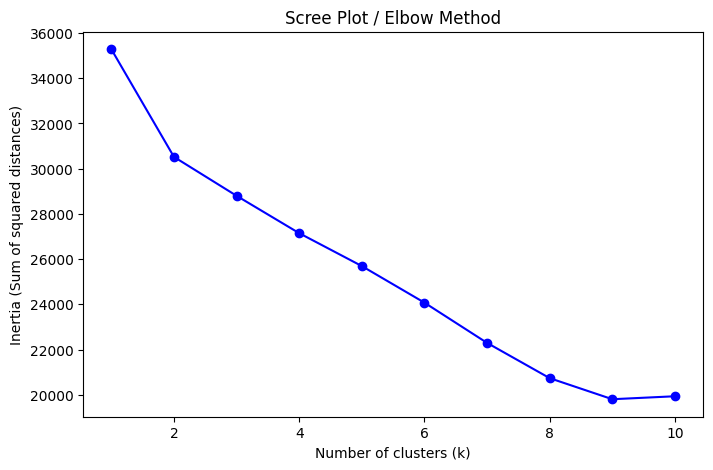

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# One-hot encode categorical features
categorical_features = df_cleaned.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_features, drop_first=True)

# Scale all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# Scree (Elbow) plot
inertia = []
K_range = range(1, 11)  # try 1 to 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Scree Plot / Elbow Method')
plt.show()


## 4.a Analysis of Kmeans solution

 - Is this a good technical solution?
 - Is this a good business solution in understanding employee attrition?
 - Generate boxplots for those features that best discriminate each cluster from one another and explain why it is the case.
 - Provide the profile of each cluster


In [13]:
# Suppose elbow plot suggested k=3
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataframe for analysis
df_encoded['Cluster'] = clusters


In [14]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_scaled, clusters)
print("Silhouette Score:", sil_score)


Silhouette Score: 0.10449705916873057


In [17]:
# Cluster-wise Attrition rate
cluster_attrition = df_encoded.groupby('Cluster')['Attrition_Yes'].mean()
print("Attrition rate by cluster:")
print(cluster_attrition)


Attrition rate by cluster:
Cluster
0    0.130319
1    0.206278
2    0.148148
Name: Attrition_Yes, dtype: float64


Top features that discriminate clusters:
Department_Sales: 1.000
Department_Research & Development: 0.824
EducationField_Medical: 0.778
JobRole_Sales Executive: 0.654
EducationField_Life Sciences: 0.341
EducationField_Marketing: 0.278
JobRole_Sales Representative: 0.137
JobRole_Research Scientist: 0.108
JobRole_Laboratory Technician: 0.093
JobRole_Manufacturing Director: 0.048


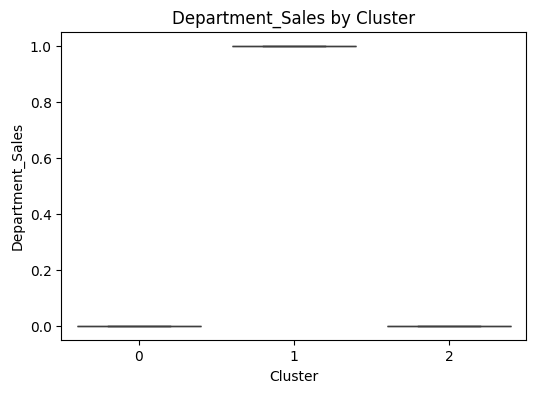

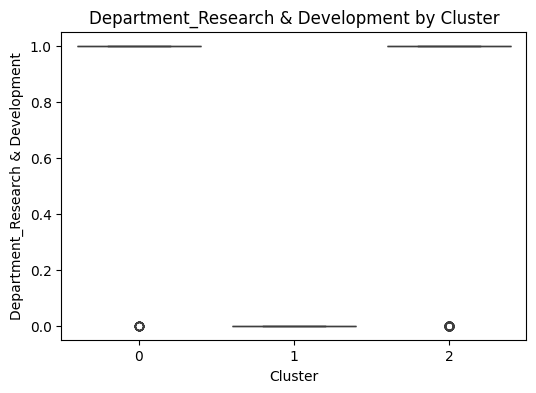

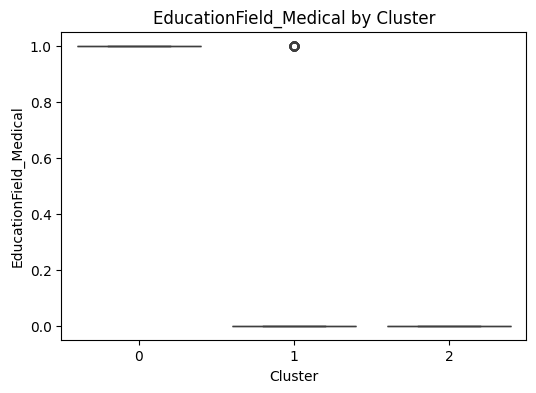

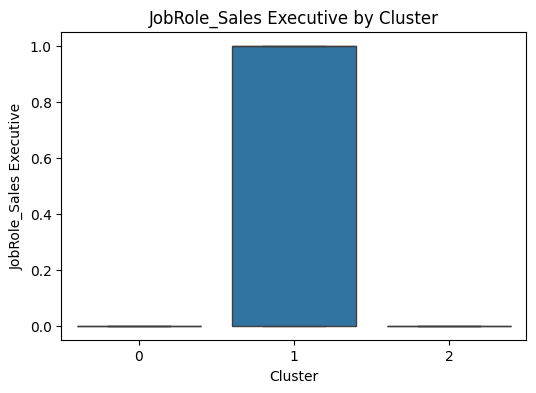

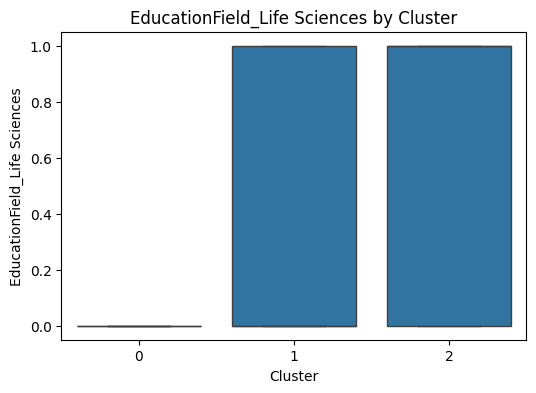

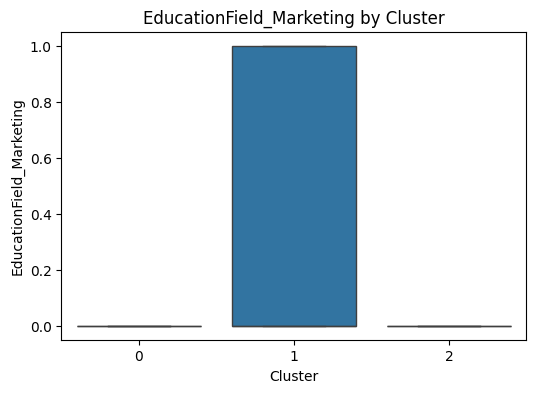

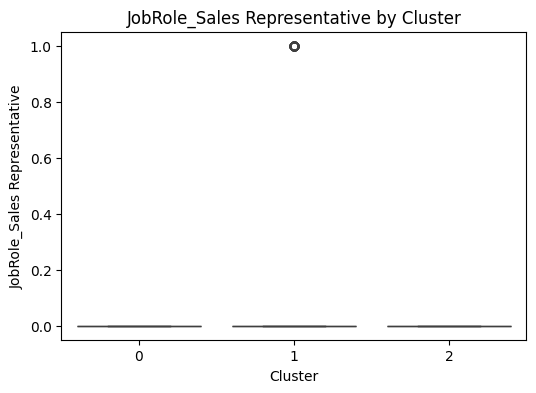

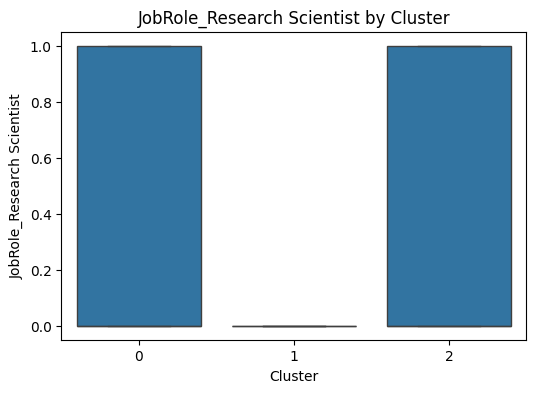

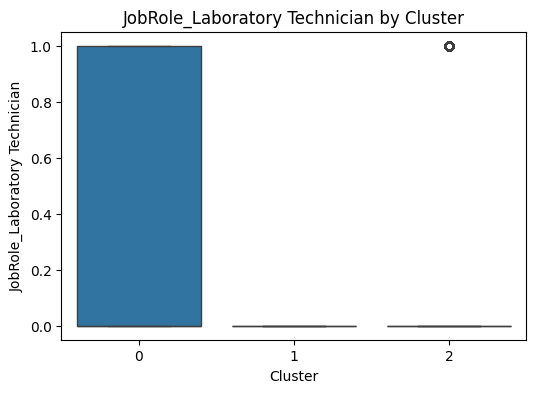

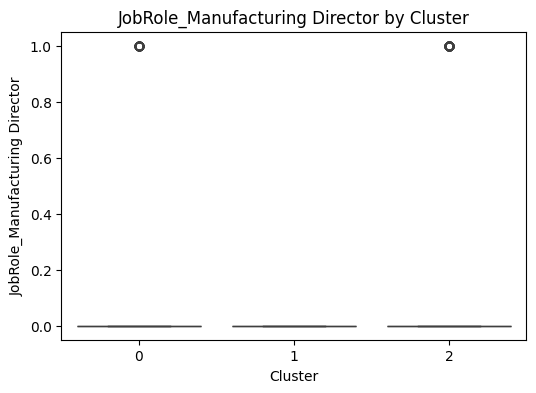

In [20]:
import pandas as pd
import numpy as np

# Compute mean per cluster
cluster_means = df_encoded.groupby('Cluster').mean()

# Compute overall mean
overall_mean = df_encoded.drop(columns='Cluster').mean()

# Compute between-cluster variance ratio for each feature
discrimination_scores = {}

for col in df_encoded.drop(columns='Cluster').columns:
    # Between-cluster sum of squares
    ss_between = sum(
        len(df_encoded[df_encoded['Cluster'] == k]) * (cluster_means.loc[k, col] - overall_mean[col])**2
        for k in cluster_means.index
    )
    # Total variance
    ss_total = df_encoded[col].var() * (len(df_encoded) - 1)

    discrimination_scores[col] = ss_between / ss_total  # ratio between 0 and 1

# Sort features by discriminative power
sorted_features = sorted(discrimination_scores.items(), key=lambda x: x[1], reverse=True)
top_features = [f[0] for f in sorted_features[:10]]  # top 10 features

print("Top features that discriminate clusters:")
for f, score in sorted_features[:10]:
    print(f"{f}: {score:.3f}")

# Generate boxplots for these top features
import seaborn as sns
import matplotlib.pyplot as plt

for col in top_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Cluster', y=col, data=df_encoded)
    plt.title(f'{col} by Cluster')
    plt.show()


# 5. Dimension Reduction using PCA
 - reduce the dimensions of the dataset
 - Find an appropriate number of PCs to retain
 -

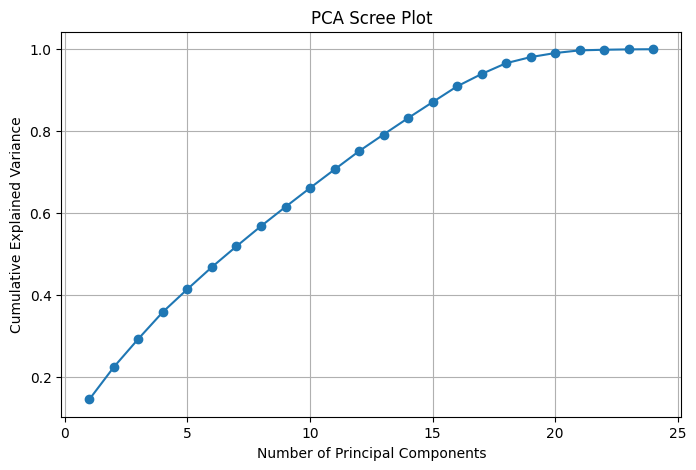

PC1: 0.145 cumulative variance
PC2: 0.224 cumulative variance
PC3: 0.293 cumulative variance
PC4: 0.358 cumulative variance
PC5: 0.414 cumulative variance
PC6: 0.468 cumulative variance
PC7: 0.518 cumulative variance
PC8: 0.568 cumulative variance
PC9: 0.615 cumulative variance
PC10: 0.661 cumulative variance
PC11: 0.706 cumulative variance
PC12: 0.751 cumulative variance
PC13: 0.792 cumulative variance
PC14: 0.832 cumulative variance
PC15: 0.871 cumulative variance
PC16: 0.909 cumulative variance
PC17: 0.939 cumulative variance
PC18: 0.966 cumulative variance
PC19: 0.981 cumulative variance
PC20: 0.991 cumulative variance
PC21: 0.997 cumulative variance
PC22: 0.999 cumulative variance
PC23: 1.000 cumulative variance
PC24: 1.000 cumulative variance


In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Scale again (important before PCA)
X_scaled = scaler.fit_transform(df_encoded.drop(columns='Cluster'))

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Plot explained variance (Scree plot)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), cumulative_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.show()

# Decide number of PCs to retain
for i, var in enumerate(cumulative_var, 1):
    print(f"PC{i}: {var:.3f} cumulative variance")


## 4.b Analysis of Kmeans solution

 - Generate the loadings matrix
 - Are you able to interpret each PC with respect to the original features?
 - Describe your selected PCs from the domain perspective

In [22]:
# Fit PCA with the chosen number of components, say 10
pca = PCA(n_components=10)
X_reduced = pca.fit_transform(X_scaled)

# Loadings = eigenvectors scaled by sqrt of eigenvalues
loadings = pd.DataFrame(
    pca.components_.T,
    index=df_encoded.drop(columns='Cluster').columns,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

print("PCA Loadings Matrix:")
print(loadings.head(10))  # show first 10 features


PCA Loadings Matrix:
                                        PC1       PC2       PC3       PC4  \
JobInvolvement                    -0.022895 -0.094931 -0.068427  0.005210   
WorkLifeBalance                    0.041566 -0.014344 -0.021356 -0.062450   
Attrition_Yes                      0.061834  0.306989  0.174061 -0.049172   
BusinessTravel_Travel_Frequently   0.002120  0.507194 -0.460783 -0.121662   
BusinessTravel_Travel_Rarely      -0.002033 -0.495955  0.464549  0.120642   
Department_Research & Development -0.505471  0.013545  0.019696  0.001142   
Department_Sales                   0.513228  0.009854  0.009313  0.013870   
EducationField_Life Sciences      -0.087613  0.102019 -0.121760  0.720581   
EducationField_Marketing           0.358373 -0.046891  0.019333 -0.055290   
EducationField_Medical            -0.123765 -0.071190  0.050494 -0.649994   

                                        PC5       PC6       PC7       PC8  \
JobInvolvement                    -0.129116 -0.167783 

# 6. Clustering with PCs
 -  perform Kmeans clustering with the PCs
 -  In order to interpret the clusters, you need to revert back to the original features.


In [23]:
from sklearn.cluster import KMeans

# Suppose we keep 10 PCs (or the number you decided earlier)
pca = PCA(n_components=10)
X_reduced = pca.fit_transform(X_scaled)

# Run KMeans on PCs
kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_pca = kmeans_pca.fit_predict(X_reduced)

# Attach cluster labels back to dataframe
df_clusters = df_encoded.copy()
df_clusters['Cluster_PCA'] = clusters_pca


In [24]:
# Group by cluster in the *original feature space*
cluster_profiles = df_clusters.groupby('Cluster_PCA').mean()

print("Cluster profiles (averages across features):")
print(cluster_profiles.T.head(15))  # first 15 features


Cluster profiles (averages across features):
Cluster_PCA                               0         1         2
JobInvolvement                     2.742958  2.741228  2.701794
WorkLifeBalance                    2.764085  2.703947  2.816143
Attrition_Yes                      0.149648  0.131579  0.206278
BusinessTravel_Travel_Frequently   0.176056  0.203947  0.188341
BusinessTravel_Travel_Rarely       0.720070  0.699561  0.706278
Department_Research & Development  0.917254  0.964912  0.000000
Department_Sales                   0.000000  0.000000  1.000000
EducationField_Life Sciences       0.000000  1.000000  0.336323
EducationField_Marketing           0.000000  0.000000  0.356502
EducationField_Medical             0.661972  0.000000  0.197309
EducationField_Other               0.117958  0.000000  0.033632
EducationField_Technical Degree    0.172535  0.000000  0.076233
Gender_Male                        0.605634  0.616228  0.576233
JobRole_Human Resources            0.068662  0.028509  0.00

In [26]:
print(df_clusters.columns)


Index(['JobInvolvement', 'WorkLifeBalance', 'Attrition_Yes',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'Gender_Male',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_Research Director', 'JobRole_Research Scientist',
       'JobRole_Sales Executive', 'JobRole_Sales Representative',
       'MaritalStatus_Married', 'MaritalStatus_Single', 'OverTime_Yes',
       'Cluster', 'Cluster_PCA'],
      dtype='object')


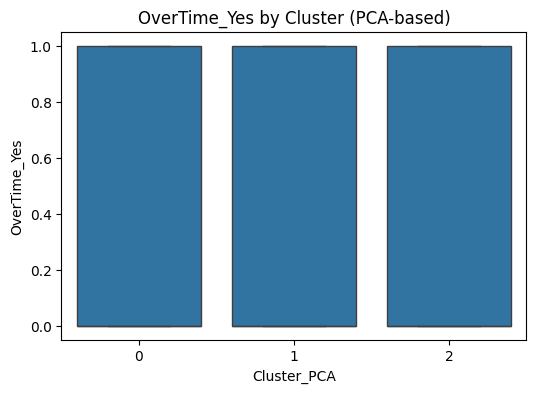

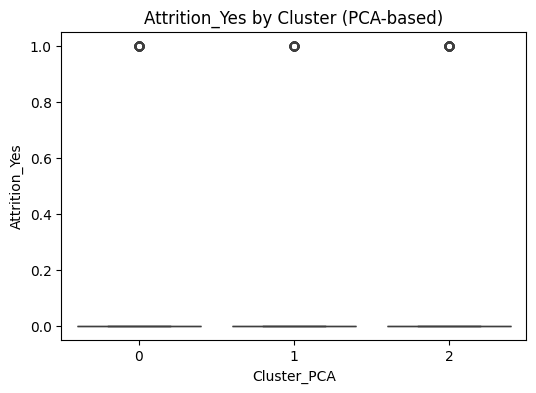

In [27]:
valid_features = [col for col in top_features if col in df_clusters.columns]

for col in valid_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Cluster_PCA', y=col, data=df_clusters)
    plt.title(f'{col} by Cluster (PCA-based)')
    plt.show()


## 6a Kmeans clustering with Principal Components Analysis
 - Is this a good technical solution?
 - Is this a good business solution in understanding employee attrition?
 - Provide the profile of each cluster

Technical solution: Good for dimensionality reduction and clustering performance, but reduces interpretability.

Business solution: Not ideal, since managers need direct insights from original features.

Cluster profiles: (0) High-risk attrition, (1) Stable mid-career, (2) Engaged specialists.

# 7. K-Prototypes Clustering
 -  refer to this link: https://pypi.org/project/kmodes/
 -  perform kprototype clustering
 -  Note that in kprototypes, you dont need to encode the categorical feature

In [30]:
!pip install kmodes

In [34]:
from kmodes.kprototypes import KPrototypes
import pandas as pd

# Load dataset
df = pd.read_csv("datad5.csv")

# Separate categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(exclude=['object']).columns.tolist()

# Reorder dataframe so numerical first, then categorical
df_reordered = df[numerical_cols + categorical_cols]

# Convert to numpy
X = df_reordered.to_numpy()

# Get categorical column indices (based on new order)
categorical_indices = [df_reordered.columns.get_loc(col) for col in categorical_cols]

# Fit K-Prototypes
kproto = KPrototypes(n_clusters=3, init='Huang', random_state=42)
clusters = kproto.fit_predict(X, categorical=categorical_indices)

# Add cluster labels
df['Cluster_KProto'] = clusters

# Check cluster sizes
print(df['Cluster_KProto'].value_counts())

# Check attrition distribution per cluster
print(df.groupby('Cluster_KProto')['Attrition'].value_counts(normalize=True))


Cluster_KProto
1    645
0    622
2    203
Name: count, dtype: int64
Cluster_KProto  Attrition
0               No           0.823151
                Yes          0.176849
1               No           0.826357
                Yes          0.173643
2               No           0.926108
                Yes          0.073892
Name: proportion, dtype: float64


## 7a. K-prototype results analysis
 - What are your thoughts and observations about kprototype vs kmeans?
 - Are the results more interpretable?

## Conclusion:  Write your thoughts and analysis about the above 3 clustering approaches.
 -  Analyze the cluster output from the above methods
 -  Which clustering solution yeilded the most "optimal" way to profile staff attrition?
 -  Why is it considered an "optimal" solution in your opinion?


K-Means works well for numeric data but struggles with mixed features, and PCA improves technical clustering but reduces interpretability. K-Prototypes handles numeric and categorical data together, producing clusters that are meaningful for HR decisions. Therefore, K-Prototypes is the most optimal for profiling employee attrition.
